# Particle detection with PyTorch Lightning 

- Pytorch
- Pytorch Lightning
- Pytorch Lightning Flash -> requires "icevision" which is deprecated (using old PyTorch version)



Check two sibling folders for examples and tutorials about PyTorch Lightning 
- Youtube tutorial: https://www.youtube.com/watch?v=UtQoZ_v57uI&list=PLhhyoLH6IjfyL740PTuXef4TstxAK6nGP&index=6
- PyTorch datasets and data loaders: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- PyTorch Lightning Flash with COCO dataset: https://lightning-flash.readthedocs.io/en/stable/reference/object_detection.html

- Forum on Pytorch on coco loading dataset: https://discuss.pytorch.org/t/how-to-efficiently-load-coco-dataset-to-dataloader/103380/5


In [1]:
# Test code for CustomCOCODataModule and CustomCocoDataset

import os
import torch
import torch.nn as nn
import numpy as np
import torchmetrics
import torch.nn.functional as F
from torch.utils.data import Dataset
#from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from torchvision.transforms.functional import resize
from PIL import Image
import matplotlib.pyplot as plt

from torchvision.utils import make_grid

from pycocotools.coco import COCO
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
from pytorch_lightning.loggers import TensorBoardLogger

import torchvision.models as models


from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

from skimage.measure import label, regionprops


os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"


data_dir_coco = '../../../../0_DATA/IMPTOX/00_Dataset/uFTIR_curated_square.v5-uftir_curated_square_2024-03-14.coco-segmentation/train'
data_dir_masks = '/mnt/remote/workspaces/thibault.schowing/0_DATA/IMPTOX/00_Dataset/uFTIR_CurSquareSemantic.v1i.png-mask-semantic/train'


NUM_WORKERS = 16



class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_transform=None):
        """
        Args:
            data_dir (string): Directory with all the images and masks.
            transform (callable, optional): Optional transform to be applied on a sample.
            target_transform (callable, optional): Optional transform to be applied on the target (mask).
            class_mode (string): 'file' for different mask files per class, 'color' for different colors in a single mask.
            color_mapping (dict): Mapping from color to class if class_mode is 'color'.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        # Get all masks for the current image (normally only one, but ready if multiple classes are present)
        masks = []
        for f in os.listdir(self.data_dir):
            #print(f"> current file: {f}")
            if f.startswith(self.image_files[idx].replace('.jpg', '')) and f.endswith('_mask.png'):
                
                mask_path = os.path.join(self.data_dir, f)
                mask = Image.open(mask_path).convert('L')
                # Resize mask to a fixed size 
                mask = mask.resize((256, 256), Image.NEAREST)
                masks.append(np.array(mask))
                
        combined_mask = np.maximum.reduce(masks)
        
        #mask = torch.tensor(combined_mask, dtype=torch.uint8)
        mask = np.array(combined_mask, dtype=np.uint8)
        

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            mask = Image.fromarray(mask)
            mask = self.target_transform(mask)

        return image, mask


class CustomDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, train_val_test_split=(0.7, 0.15, 0.15)):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_val_test_split = train_val_test_split

    def setup(self, stage=None):
        
       # Define transforms
        transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize images to 256x256
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        target_transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize images to 256x256
            transforms.ToTensor()
            ])

        
        # Load dataset
        self.dataset = CustomDataset(self.data_dir, transform=transform, target_transform=target_transform)
        
        # Split dataset into train, val, and test
        # Calculate split sizes
        train_size = int(self.train_val_test_split[0] * len(self.dataset))
        val_size = int(self.train_val_test_split[1] * len(self.dataset))
        test_size = len(self.dataset) - train_size - val_size
        self.train_data, self.val_data, self.test_data = random_split(self.dataset, [train_size, val_size, test_size])

    def train_dataloader(self):
        return DataLoader(self.train_data, num_workers = NUM_WORKERS, pin_memory=True, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, num_workers = NUM_WORKERS, pin_memory=True, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_data, num_workers = NUM_WORKERS, pin_memory=True, batch_size=self.batch_size)



# ----------------------------------
# Instantiate the CustomDataModule
# ----------------------------------

data_dir = '/mnt/remote/workspaces/thibault.schowing/0_DATA/IMPTOX/00_Dataset/uFTIR_CurSquareSemantic.v1i.png-mask-semantic/train'
batch_size = 4
train_val_test_split = (0.6, 0.2, 0.2)



dm = CustomDataModule(data_dir, batch_size = batch_size, train_val_test_split=train_val_test_split)
dm.setup()



In [2]:
# ----------------------------------
# Loss functions
# ----------------------------------

# ---------------------
# Dice loss
# ---------------------

def dice_coefficient(y_hat, y, smooth=1e-6):
    # Flatten the tensors
    y_hat = y_hat.view(-1)
    y = y.view(-1)
    
    # Calculate the intersection and union
    intersection = (y_hat * y).sum()
    union = y_hat.sum() + y.sum()
    
    # Compute the dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return dice

def dice_loss(y_hat, y, smooth=1e-6):
    dice = dice_coefficient(y_hat, y, smooth)
    return 1 - dice


# ---------------------
# Jaccard Index
# ---------------------

class NegativeBinaryJaccardIndex(nn.Module):
    def __init__(self):
        super(NegativeBinaryJaccardIndex, self).__init__()

    def forward(self, input, target):
        smooth = 1e-6
        intersection = (input * target).sum()
        union = input.sum() + target.sum() - intersection
        jaccard_index = (intersection + smooth) / (union + smooth)
        
        
        return 1 - jaccard_index  # Return 1 - Jaccard Index as the loss
    
# ---------------------
# F1 and F2 score
# ---------------------

class F1Loss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(F1Loss, self).__init__()
        self.epsilon = epsilon

    def forward(self, y_hat, y):
        y_hat = torch.sigmoid(y_hat)
        y_hat = y_hat.view(-1)
        y = y.view(-1)
        
        tp = (y_hat * y).sum()
        fp = ((1 - y) * y_hat).sum()
        fn = (y * (1 - y_hat)).sum()
        
        f1 = (2 * tp + self.epsilon) / (2 * tp + fp + fn + self.epsilon)
        return  -f1
    
class F2Loss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(F2Loss, self).__init__()
        self.epsilon = epsilon

    def forward(self, y_hat, y):
        y_hat = torch.sigmoid(y_hat)
        y_hat = y_hat.view(-1)
        y = y.view(-1)
        
        tp = (y_hat * y).sum()
        fp = ((1 - y) * y_hat).sum()
        fn = (y * (1 - y_hat)).sum()
        
        # How many retrieved items are relevant / how many relevant items are retrieved        
        f2 = (15 * tp + self.epsilon) / (2 * tp + fp + fn + self.epsilon)
        return  -f2
    
# ---------------------
# IOU loss function 
# ---------------------

class IOULoss(nn.Module):
    def __init__(self):
        super(IOULoss, self).__init__()

    def forward(self, y_hat, y):
        y_hat = torch.sigmoid(y_hat)
        y_hat = y_hat.view(-1)
        y = y.view(-1)
        
        intersection = (y_hat * y).sum()
        union = y_hat.sum() + y.sum() - intersection

        # Ensure union is not zero to prevent division by zero
        union = torch.clamp(union, min=1e-6)
        
        iou = intersection / union
        return -iou



In [3]:
torch.cuda.empty_cache() 

### First Simple Model

In [6]:

# ---------------------
# Simple segmentation - Fully convolutional 
# ---------------------

class SimpleSegmentationNN(pl.LightningModule):
    def __init__(self, in_channels, out_channels, learning_rate):
        super().__init__()
        self.lr = learning_rate
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.iou = BinaryJaccardIndex()
        self.f1_score = BinaryF1Score()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y = y.float()  # Ensure target is of type float
        
        # Print the min and max values of y_hat to check if they are logits
        #print("y_hat min:", y_hat.min().item(), "y_hat max:", y_hat.max().item())
        
        loss = self.loss_fn(y_hat, y)
        preds = torch.sigmoid(y_hat) > 0.5
        
        #print("preds min:", preds.min().item(), "preds max:", preds.max().item())
        
        iou = self.iou(preds, y.int())
        f1_score = self.f1_score(preds, y.int())
        self.log_dict(
            {
                "train_loss": loss,
                "train_iou": iou,
                "train_f1_score": f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y = y.float()  # Ensure target is of type float
        loss = self.loss_fn(y_hat, y)
        preds = torch.sigmoid(y_hat) > 0.5
        iou = self.iou(preds, y.int())
        f1_score = self.f1_score(preds, y.int())
        self.log("val_loss", loss)
        self.log("val_iou", iou)
        self.log("val_f1_score", f1_score)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y = y.float()  # Ensure target is of type float
        loss = self.loss_fn(y_hat, y)
        preds = torch.sigmoid(y_hat) > 0.5
        iou = self.iou(preds, y.int())
        f1_score = self.f1_score(preds, y.int())
        self.log("test_loss", loss)
        self.log("test_iou", iou)
        self.log("test_f1_score", f1_score)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    



# Define model parameters
in_channels = 3  # Number of channels in the input images (e.g., 3 for RGB)
out_channels = 1  # Number of classes (1 for binary segmentation)
learning_rate = 1e-3
ACCELERATOR = "gpu"
DEVICES = [0,1]
PRECISION = 16

# Instantiate the model
model = SimpleSegmentationNN(in_channels, out_channels, learning_rate)

# Set up the TensorBoard logger
logger = TensorBoardLogger("tb_logs", name="simple_segmentation")

# Define the PyTorch Lightning Trainer

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    devices=DEVICES,
    min_epochs=1,
    max_epochs=10,
    precision=PRECISION, 
    logger=logger
)

# Train, validate and test the model
trainer.fit(model, dm)
trainer.validate(model, dm)
trainer.test(model, dm)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/simple_segmentation
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type               | Params
------------------------------------------------
0 | encoder  | Sequential         | 75.6 K
1 | decoder  | Sequential         | 33.1 K
2 | loss_fn  | BCEWithLogitsLoss  | 0     
3 | iou      | BinaryJaccardIndex | 0     
4 | f1_score | BinaryF1Score      | 0     
------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.217     Total estimated model params size (MB)


Epoch 0:  50%|█████     | 35/70 [00:02<00:02, 14.13it/s, loss=0.693, v_num=0]

/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 38.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.validating metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_f1_score                  0.0
         val_iou                    nan
        val_loss            0.6931473016738892
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 35.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_score                 0.0
        test_iou                    nan
        test_loss           0.6931473016738892
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6931473016738892, 'test_iou': nan, 'test_f1_score': 0.0}]

In [ ]:
!tensorboard --logdir tb_logs


### Unet with ResNet50 encoder

manual implementation from https://github.com/rawmarshmellows/pytorch-unet-resnet-50-encoder/blob/master/u_net_resnet_50_encoder.py



In [12]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet50, ResNet50_Weights


learning_rate = 1e-2
ACCELERATOR = "gpu"
DEVICES = [0]
PRECISION = 16


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()
        
        # Loss function
        #self.loss_fn = nn.BCEWithLogitsLoss()
        self.loss_fn = nn.MSELoss()
        
        # Metrics
        self.iou = BinaryJaccardIndex()
        self.f1_score = BinaryF1Score()
        

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50EncoderPL1(pl.LightningModule):
    DEPTH = 6

    def __init__(self, learning_rate, n_classes=1):
        super().__init__()
        
        self.learning_rate = learning_rate
        # Loss function
        self.loss_fn = nn.MSELoss() # nn.BCEWithLogitsLoss()
        
        # Metrics
        self.iou = BinaryJaccardIndex()
        self.f1_score = BinaryF1Score()
        
        
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y = y.float()  # Ensure target is of type float
        loss = self.loss_fn(y_hat, y)
        preds = torch.sigmoid(y_hat) > 0.5
        iou = self.iou(preds, y.int())
        f1_score = self.f1_score(preds, y.int())
        self.log_dict(
            {
                "train_loss": loss,
                "train_iou": iou,
                "train_f1_score": f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y = y.float()  # Ensure target is of type float
        loss = self.loss_fn(y_hat, y)
        preds = torch.sigmoid(y_hat) > 0.5
        iou = self.iou(preds, y.int())
        f1_score = self.f1_score(preds, y.int())
        self.log("val_loss", loss)
        self.log("val_iou", iou)
        self.log("val_f1_score", f1_score)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y = y.float()  # Ensure target is of type float
        loss = self.loss_fn(y_hat, y)
        preds = torch.sigmoid(y_hat) > 0.5
        iou = self.iou(preds, y.int())
        f1_score = self.f1_score(preds, y.int())
        self.log("test_loss", loss)
        self.log("test_iou", iou)
        self.log("test_f1_score", f1_score)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)



model = UNetWithResnet50EncoderPL1(learning_rate, n_classes=1).cuda()
#inp = torch.rand((2, 3, 512, 512)).cuda()
#out = model(inp)

# Set up the TensorBoard logger
logger = pl.loggers.TensorBoardLogger("tb_logs", name="resnet50_segmentation")

# Define the PyTorch Lightning Trainer
# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    devices=DEVICES,
    min_epochs=1,
    max_epochs=20,
    precision=PRECISION,
    logger=logger  # Add the TensorBoard logger
)

# Train, validate and test the model
trainer.fit(model, dm)
trainer.validate(model, dm)
trainer.test(model, dm)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type               | Params
---------------------------------------------------
0 | loss_fn     | MSELoss            | 0     
1 | iou         | BinaryJaccardIndex | 0     
2 | f1_score    | BinaryF1Score      | 0     
3 | input_block | Sequential         | 9.5 K 
4 | input_pool  | MaxPool2d          | 0     
5 | down_blocks | ModuleList         | 23.5 M
6 | bridge      | Bridge             | 75.5 M
7 | up_blocks   | ModuleList         | 48.8 M
8 | out         | Conv2d             | 65    
---------------------------------------------------
147 M     Trainable params
0         Non-trainable params
147 M     Total params
295.617   Total estimated model params size (MB)


Epoch 0:   3%|▎         | 2/70 [00:01<00:52,  1.30it/s, loss=1.87, v_num=77] 

/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation DataLoader 0: 100%|██████████| 18/18 [00:02<00:00,  6.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.validating metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_f1_score                  0.0
         val_iou                    0.0
        val_loss                2210668.25
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 18/18 [00:02<00:00,  6.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_score                 0.0
        test_iou                    0.0
        test_loss               2214861.75
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2214861.75, 'test_iou': 0.0, 'test_f1_score': 0.0}]

### Unet (second version - model and lightning separated)




In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet50, ResNet50_Weights

learning_rate = 1e-3
ACCELERATOR = "gpu"
DEVICES = [0]
PRECISION = 16
MAX_EPOCH = 50

#BCEwithLogitsLoss
POSITIVE_CLASS_WEIGHT = 0.95


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x





class UNetWithResnet50EncoderPL(pl.LightningModule):
    DEPTH = 6

    def __init__(self, learning_rate, n_classes=1):
        super().__init__()
        
        # WORKS
        #self.model = UNetWithResnet50Encoder(n_classes).cuda()
        
        
        
        self.learning_rate = learning_rate
        
        # Loss function
        # in old loss function chapter bellow -> self.loss_fn = CombinedLoss(torch.tensor(POSITIVE_CLASS_WEIGHT))
        #self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(POSITIVE_CLASS_WEIGHT))
        #self.loss_fn = NegativeBinaryJaccardIndex()
        #self.loss_fn = nn.BCEWithLogitsLoss()
        
        
        #self.loss_fn = F2Loss() # IT WORKS
        # [{'test_loss': -0.057264022529125214, 'test_iou': 0.24490104615688324, 'test_f1_score': 0.3871413767337799}]
        
        
        
        self.loss_fn = IOULoss() # IT WORKS
        # [{'test_loss': -0.0038152062334120274, 'test_iou': 0.19489172101020813, 'test_f1_score': 0.3240705728530884}]
        # Without image normalization: [{'test_loss': -0.003855716437101364, 'test_iou': 0.27566251158714294, 'test_f1_score': 0.42972472310066223}]
        
        # Metrics
        self.iou = BinaryJaccardIndex()
        self.f1_score = BinaryF1Score()
        

        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.float()  # Ensure target is of type float
        
        
        #print(f"Tensor whape y_hat: {y_hat.shape}")
        #print(f"Tensor shape y: {y.shape}")
        
        preds = torch.sigmoid(y_hat) > 0.5
        loss = self.loss_fn(y_hat, y)
        
        
        #print(f"\npreds unique {preds.unique()}")
        #print(f"y unique {y.unique()}")
        #print(f"Loss: {loss}")
        
        iou = self.iou(preds.bool(), y.bool())
        f1_score = self.f1_score(preds, y.bool())
        
        
        #print(f"F1 score: {f1_score}")
        
        
        self.log_dict(
            {
                "train_loss": loss,
                "train_iou": iou,
                "train_f1_score": f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.float()  # Ensure target is of type float
        
        
        preds = torch.sigmoid(y_hat) > 0.5
        
        loss = self.loss_fn(y_hat, y)
        
        #print("preds unique")
        #print(preds.unique())
        
        iou = self.iou(preds.bool(), y.bool())
        f1_score = self.f1_score(preds, y.bool())
        self.log("val_loss", loss)
        self.log("val_iou", iou)
        self.log("val_f1_score", f1_score)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.float()  # Ensure target is of type float
        
        
        preds = torch.sigmoid(y_hat) > 0.5
        loss = self.loss_fn(y_hat, y)
        
        
        iou = self.iou(preds.bool(), y.bool())
        f1_score = self.f1_score(preds, y.bool())
        self.log("test_loss", loss)
        self.log("test_iou", iou)
        self.log("test_f1_score", f1_score)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)




model = UNetWithResnet50EncoderPL(learning_rate, n_classes=1).cuda()

# TODO
# Check parameters for trainable backbone layers: https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn
#model = models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT, num_classes=1, progress=True)


# Set up the TensorBoard logger
logger = pl.loggers.TensorBoardLogger("tb_logs", name="resnet50_segmentation")

# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    devices=DEVICES,
    min_epochs=1,
    max_epochs=MAX_EPOCH,
    #precision=PRECISION,
    logger=logger  # Add the TensorBoard logger
)

# Train, validate and test the model
trainer.fit(model, dm)
trainer.validate(model, dm)
trainer.test(model, dm)


## Mask Rcnn Resnet50 FPN

Test with the same architecture as used with detectron2. We need to modify the architecture for 1 class instead of 91 -> done
Problem with the format returned by the model -> we get dict AND lists which contain various elements. 


TODO: 
- check the batch image and target. Is it really needed to put them into a list etc ? can we do .to_device() later ?
- check the loss function etc
- make it work


### Test without training

We get some detection in one of the 90 classes 

In [7]:

from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

import torch
import torchvision.models as models
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
import matplotlib.pyplot as plt
import numpy as np


sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(MaskRCNN_ResNet50_FPN_Weights.DEFAULT.meta["categories"])}
print(sem_class_to_idx)

# Function to visualize image, ground truth mask, and prediction
def visualize_predictions(images, masks, predictions):
    
    for i in range(len(images)):
        
        # Matching classes from sem_class_to_idx for each prediction number: 
        labs = [list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(idx)] for idx in predictions[i]['labels']]
        print(labs)
        
        img = images[i].cpu()
        gt_mask = masks[i].cpu().numpy()
        pred_mask = predictions[i]['masks'].cpu().numpy()

        # Convert to PIL Image for better visualization
        img = to_pil_image(img)
        
        # Plot image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')
        
        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask[0], alpha=0.5, cmap='viridis')
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Plot prediction mask
        if pred_mask.shape[0] > 0:
            pred_mask = pred_mask[0, 0]
        else:
            pred_mask = np.zeros_like(gt_mask[0])
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, alpha=0.5, cmap='viridis')
        plt.title('Prediction')
        plt.axis('off')
        
        plt.show()

# Assuming data_module is already defined and set up
data_module = CustomDataModule(data_dir, batch_size=4, train_val_test_split=train_val_test_split)
data_module.setup()

{'__background__': 0, 'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'N/A': 83, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 

Images shapes: torch.Size([4, 3, 256, 256])
Images types: torch.float32
Masks shapes: torch.Size([4, 1, 256, 256])
Masks types: torch.float32
['traffic light', 'clock', 'clock']


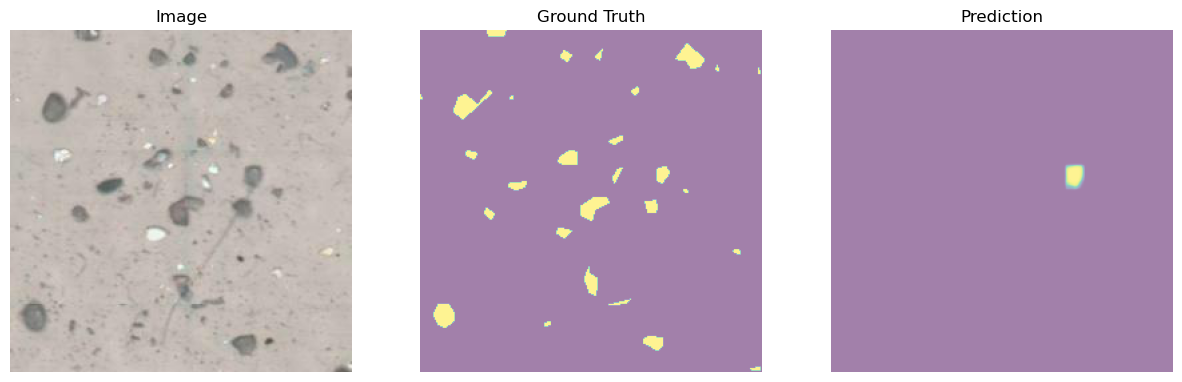

[]


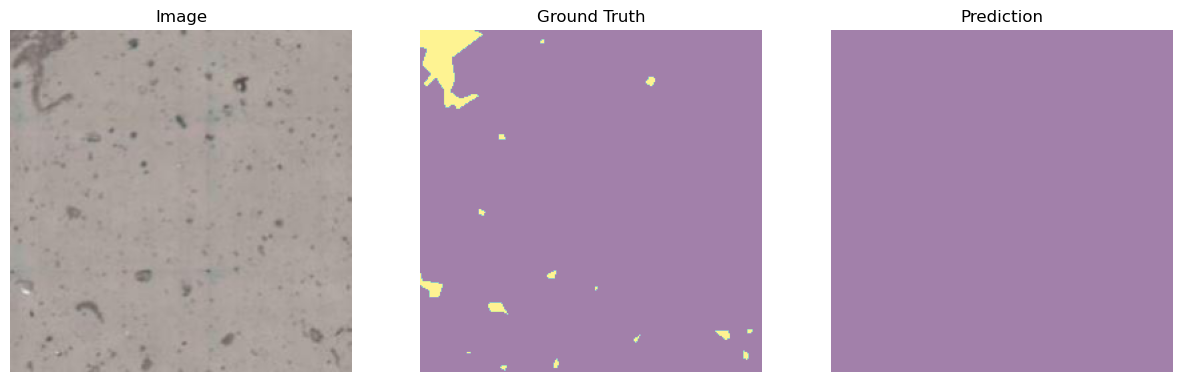

[]


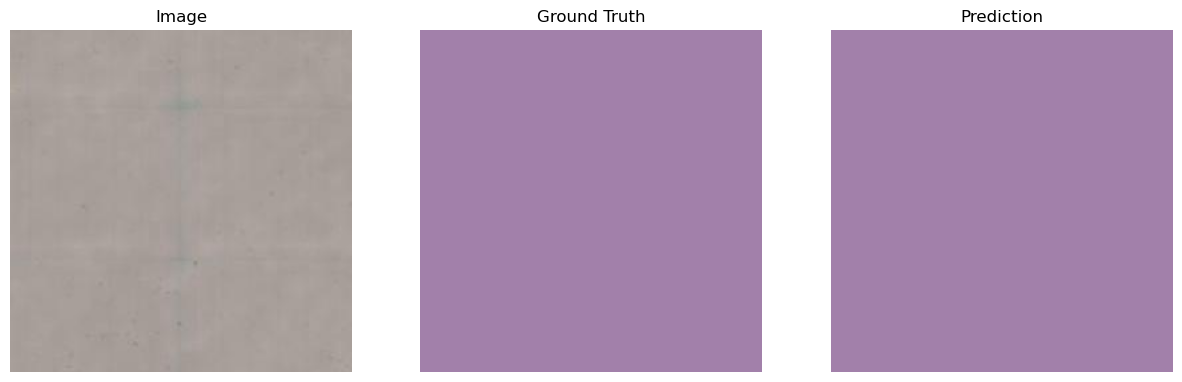

[]


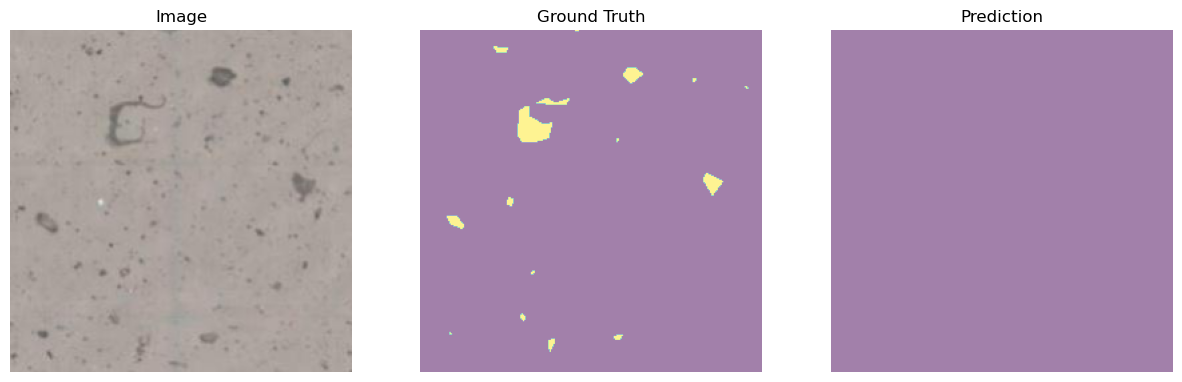

In [8]:



model = models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
model.to('cuda')


# Function to visualize image, ground truth mask, and prediction

def get_data(dataloader):
    
    images, masks = next(iter(dataloader))
    
    print(f"Images shapes: {images.shape}")
    print(f"Images types: {images.dtype}")
    print(f"Masks shapes: {masks.shape}")
    print(f"Masks types: {masks.dtype}")

    # Move images to the correct device
    images = [img.to('cuda') for img in images]

    # Generate predictions
    with torch.no_grad():
        predictions = model(images)
        #print(f"Prediction keys: {predictions[0].keys()}")

    # Visualize results
    visualize_predictions(images, masks, predictions)
    


get_data(data_module.train_dataloader())




### PyTorch transfer learning 
From https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html


In [11]:



import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# ----------------------------------

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

# ----------------------------------

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model




Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /home/thibault.schowing/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 96.4MB/s]


In [ ]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

train_data_loader = data_module.train_dataloader()
test_data_loader = data_module.test_dataloader()

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_data_loader, device=device)

print("That's it!")

### PyTorch Lightning transfer learning

The tutorial bellow seem to indicate a basic way to perform this transfer learning from a coco dataset. 

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Interestingly they have some helper function in https://github.com/pytorch/vision/blob/main/references/detection/engine.py for instance. 

Also interesting, in the dataset they generate bbox for each mask. Which can cause troubles here as we have semantic annotation masks. It could be wise to modify the "to_target" function bellow to generate more accurate data annotations for our dataset. 


To create bounding boxes, check here: 
https://stackoverflow.com/questions/73282135/computing-bounding-boxes-from-a-mask-image-tensorflow-or-other



In [11]:

from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights

class MaskRCNNLightningModule(pl.LightningModule):
    def __init__(self, num_classes: int = 2, learning_rate: float = 0.005):
        super(MaskRCNNLightningModule, self).__init__()
        
        # Load Mask R-CNN model pre-trained on COCO
        self.model = models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
        
        # Modify the head of the model to match the number of classes
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
        
        # Modify the mask head
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        self.model.roi_heads.mask_predictor = models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
        
        # Lower the detection threshold
        self.model.roi_heads.score_thresh = 0.05
        
        self.learning_rate = learning_rate
        self.loss_fn = F2Loss() 
        
    def forward(self, images, targets=None):
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, binary_masks = batch
        images = list(image.to(self.device) for image in images)
        targets = self.create_targets(images, binary_masks)
        
        # Print targets for debugging
        #for target in targets:
        #    
        #    print(f"Training target boxes: {target['boxes']}")
        #    print(f"Training target labels: {target['labels']}")
        #    print(f"Training target masks shape: {target['masks'].shape}")
        #    print(f"Training target masks unique values: {target['masks'].unique()}")

        # Forward pass
        loss_dict = self.forward(images, targets)
        
        # Print losses for debugging
        print(f"Loss dict: {loss_dict}")
        mask_loss = loss_dict.get("loss_mask")
        print(f"mask loss: {mask_loss}")
        
        losses = sum(loss for loss in loss_dict.values())
        print(f"Sum train_loss: {losses}")
        self.log('train_loss', losses, on_step=False, on_epoch=True, prog_bar=True)
        return mask_loss


    def validation_step(self, batch, batch_idx):
        images, binary_masks = batch
        images = list(image.to(self.device) for image in images)
        targets = self.create_targets(images, binary_masks)

        # Forward pass
        outputs = self.forward(images)

        # Extract highest scoring predicted masks or handle empty scores
        pred_masks = []
        for output in outputs:
            scores = output['scores']
            if scores.numel() == 0:
                # Create a dummy mask if no objects are detected
                _, h, w = images[0].shape
                dummy_mask = torch.zeros((1, h, w), device=self.device)
                pred_masks.append(dummy_mask)
            else:
                highest_score_idx = scores.argmax()
                pred_mask = output['masks'][highest_score_idx]
                pred_masks.append(pred_mask)
                
        pred_masks = torch.stack(pred_masks).squeeze(1)  # Stack along batch dimension

        # Extract target masks
        target_masks = torch.cat([target['masks'] for target in targets]).squeeze(1)

        # Resize predicted masks to match target mask size
        pred_masks = nn.functional.interpolate(pred_masks.unsqueeze(1), size=target_masks.shape[1:], mode="bilinear", align_corners=False).squeeze(1)

        # Compute loss
        val_loss = self.loss_fn(pred_masks, target_masks)
        print(f"Val_loss: {val_loss}")
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return val_loss



        
    def test_step(self, batch, batch_idx):
        images, binary_masks = batch
        images = list(image.to(self.device) for image in images)
        targets = self.create_targets(images, binary_masks)

        # Forward pass
        outputs = self.forward(images)

        # Extract highest scoring predicted masks or handle empty scores
        pred_masks = []
        for output in outputs:
            scores = output['scores']
            if scores.numel() == 0:
                # Create a dummy mask if no objects are detected
                _, h, w = images[0].shape
                dummy_mask = torch.zeros((1, h, w), device=self.device)
                pred_masks.append(dummy_mask)
            else:
                highest_score_idx = scores.argmax()
                pred_mask = output['masks'][highest_score_idx]
                pred_masks.append(pred_mask)
        pred_masks = torch.stack(pred_masks).squeeze(1)  # Stack along batch dimension

        # Extract target masks
        target_masks = torch.cat([target['masks'] for target in targets]).squeeze(1)

        # Resize predicted masks to match target mask size
        pred_masks = nn.functional.interpolate(pred_masks.unsqueeze(1), size=target_masks.shape[1:], mode="bilinear", align_corners=False).squeeze(1)

        # Compute loss
        test_loss = self.loss_fn(pred_masks, target_masks)
        self.log('test_loss', test_loss, on_step=False, on_epoch=True, prog_bar=True)
        return test_loss


    
    def create_targets(self, images, binary_masks):
        targets = []
        for mask in binary_masks:
            mask = mask.to(self.device)
            mask = torch.sigmoid(mask) > 0.5
            _, h, w = mask.shape
            
            # Create bounding boxes around each regionprops object
            
            mask_1 = mask[:,:,0].to('cpu').numpy().astype(np.uint8)
            lbl_0 = label(mask_1) 
            
            #print(f"Label: {lbl_0}")
            
            props = regionprops(lbl_0)
            boxes = []
            
            for prop in props:
                #print('Found bbox', prop.bbox)
                boxes.append(prop.bbox)
            
            if len(boxes) == 0:
                boxes = torch.tensor([[0, 0, 0, 0]], dtype=torch.float32).to(self.device)  # Ensure the correct shape
            else:
                boxes = torch.tensor(boxes, dtype=torch.float32).to(self.device)
            
            #boxes = torch.tensor([[0, 0, w, h]], dtype=torch.float32).to(self.device)
            
            # ------------------------
            labels = torch.ones((1,), dtype=torch.int64).to(self.device)  # Single class
            masks = mask.unsqueeze(0).float()
            target = {'boxes': boxes, 'labels': labels, 'masks': masks}
            targets.append(target)
        return targets


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)




In [12]:
# Initialize the PyTorch Lightning model
torch.cuda.empty_cache() 

num_classes=2
learning_rate=0.005

ACCELERATOR = "gpu"
DEVICES = [0]
PRECISION = 16
MAX_EPOCH = 2



model = MaskRCNNLightningModule(num_classes=num_classes, learning_rate=learning_rate)

# Set up the TensorBoard logger
logger = pl.loggers.TensorBoardLogger("tb_logs", name="resnet50_segmentation")

# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    devices=DEVICES,
    min_epochs=1,
    max_epochs=MAX_EPOCH,
    precision=PRECISION,
    logger=logger  # Add the TensorBoard logger
)

# Train, validate and test the model

trainer.fit(model, dm)


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type     | Params
-------------------------------------
0 | model   | MaskRCNN | 43.9 M
1 | loss_fn | F2Loss   | 0     
-------------------------------------
43.7 M    Trainable params
222 K     Non-trainable params
43.9 M    Total params
87.845    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/274 [00:00<?, ?it/s]                           

/opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [3,0,0], thread: [81,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [6]:
trainer.validate(model, dm)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:315: PossibleUserWarning: Using `DistributedSampler` with the dataloaders. During `trainer.validate()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven inputs.
  rank_zero_warn(
/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:208: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() a

Validation DataLoader 0: 100%|██████████| 35/35 [00:05<00:00,  5.89it/s]

/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:539: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Validation DataLoader 0: 100%|██████████| 35/35 [00:05<00:00,  5.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.validating metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            -0.8709790706634521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': -0.8709790706634521}]

In [7]:
trainer.test(model, dm)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:315: PossibleUserWarning: Using `DistributedSampler` with the dataloaders. During `trainer.test()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven inputs.
  rank_zero_warn(
/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/l

Testing DataLoader 0: 100%|██████████| 35/35 [00:06<00:00,  5.81it/s]

/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:539: PossibleUserWarning: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Testing DataLoader 0: 100%|██████████| 35/35 [00:06<00:00,  5.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.8848903775215149
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -0.8848903775215149}]

# Visualize Model results 


In [6]:

# Assuming you have a DataLoader for validation data
val_loader = dm.val_dataloader()


# Create an iterator for the DataLoader
val_loader_iter = iter(val_loader)

# Select the right device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# Set the model to evaluation mode
model.to(device)
model.eval()


# Number of batches to visualize
for i in range(1):
    try:
        # Run validation loop to get a sample input and ground truth
        sample_input, ground_truth = next(val_loader_iter)
    except StopIteration:
        # If the iterator is exhausted, create a new one
        val_loader_iter = iter(val_loader)
        sample_input, ground_truth = next(val_loader_iter)

    # Ensure the sample_input and ground_truth are on the correct device
    #sample_input = sample_input.cuda()
    #ground_truth = ground_truth.cuda()
    
    # Other method
    sample_input = [img.to(device) for img in sample_input]
    ground_truth = [t.to(device) for t in ground_truth]

    #print(f"Sample input shape: {sample_input[0].shape}") # torch.Size([3, 256, 256])
    
    # Print shapes and types for debugging
    print("Sample input shapes:", [img.shape for img in sample_input])
    print("Ground truth:", [g.shape for g in ground_truth])
    
    # Generate predictions
    with torch.no_grad():
        predictions = model(sample_input)
    
    print(predictions)

    


Sample input shapes: [torch.Size([3, 256, 256]), torch.Size([3, 256, 256]), torch.Size([3, 256, 256]), torch.Size([3, 256, 256])]
Ground truth: [torch.Size([1, 256, 256]), torch.Size([1, 256, 256]), torch.Size([1, 256, 256]), torch.Size([1, 256, 256])]
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'masks': tensor([], device='cuda:0', size=(0, 1, 256, 256))}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'masks': tensor([], device='cuda:0', size=(0, 1, 256, 256))}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'masks': tensor([], device='cuda:0', size=(0, 1, 256, 256))}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'sc

Validate the Ground Truth and Predictions
Print detailed information about the ground truth and predictions to ensure they are correctly formatted and being processed.

Image 0:
Boxes: tensor([], device='cuda:0', size=(0, 4))
Labels: tensor([], device='cuda:0', dtype=torch.int64)
Scores: tensor([], device='cuda:0')
Masks shape: torch.Size([0, 1, 256, 256])
Scores above threshold: tensor([], device='cuda:0')
Image 1:
Boxes: tensor([], device='cuda:0', size=(0, 4))
Labels: tensor([], device='cuda:0', dtype=torch.int64)
Scores: tensor([], device='cuda:0')
Masks shape: torch.Size([0, 1, 256, 256])
Scores above threshold: tensor([], device='cuda:0')
Image 2:
Boxes: tensor([], device='cuda:0', size=(0, 4))
Labels: tensor([], device='cuda:0', dtype=torch.int64)
Scores: tensor([], device='cuda:0')
Masks shape: torch.Size([0, 1, 256, 256])
Scores above threshold: tensor([], device='cuda:0')
Image 3:
Boxes: tensor([], device='cuda:0', size=(0, 4))
Labels: tensor([], device='cuda:0', dtype=torch.int64)
Scores: tensor([], device='cuda:0')
Masks shape: torch.Size([0, 1, 256, 256])
Scores above threshold: tensor([], device='cuda:0')
Predictions: {'boxes': tensor([]

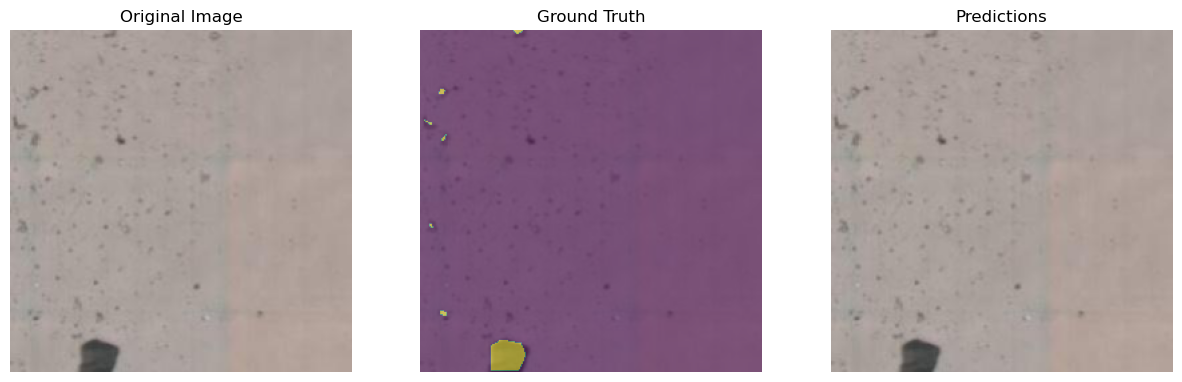

Predictions: {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'masks': tensor([], device='cuda:0', size=(0, 1, 256, 256))}


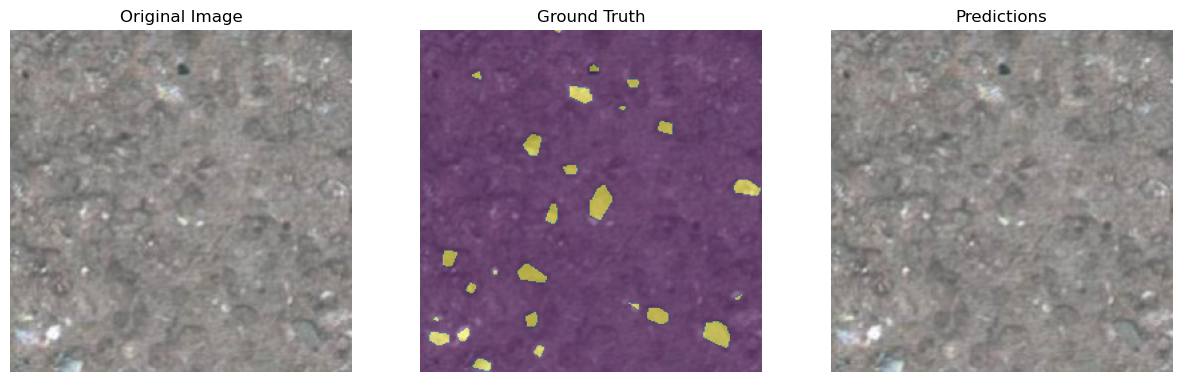

Predictions: {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'masks': tensor([], device='cuda:0', size=(0, 1, 256, 256))}


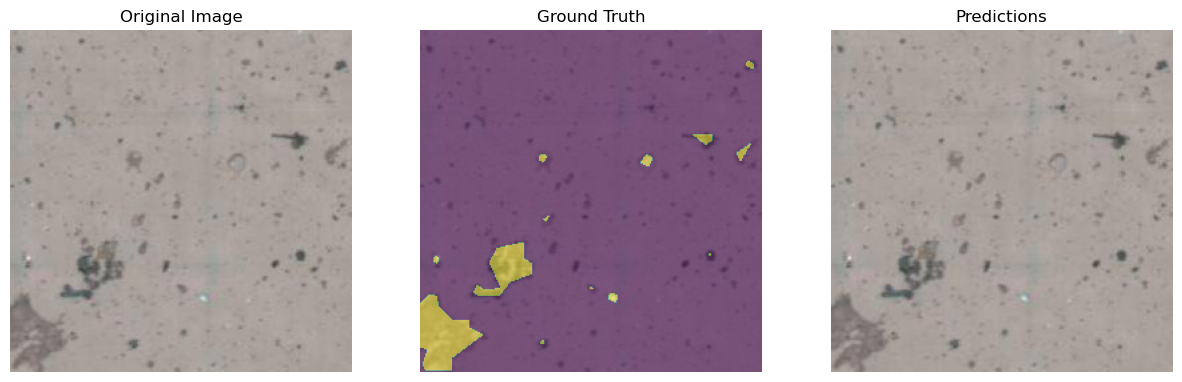

Predictions: {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'masks': tensor([], device='cuda:0', size=(0, 1, 256, 256))}


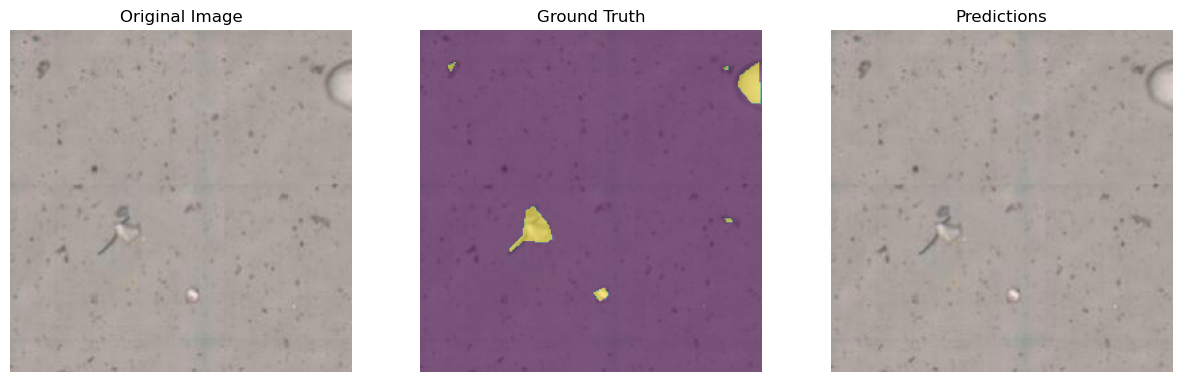

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is on the correct device and set to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()


# Define a lower confidence threshold
confidence_threshold = 0.05

# Number of batches to visualize
for _ in range(1):
    try:
        # Run validation loop to get a sample input and ground truth
        sample_input, ground_truth = next(val_loader_iter)
    except StopIteration:
        # If the iterator is exhausted, create a new one
        val_loader_iter = iter(val_loader)
        sample_input, ground_truth = next(val_loader_iter)

    # Ensure the sample_input is on the correct device
    sample_input = [img.to(device) for img in sample_input]

    # Convert ground truth masks using the create_targets function
    ground_truth_converted = model.create_targets(sample_input, ground_truth)

    # Generate predictions
    with torch.no_grad():
        predictions = model(sample_input)
        
    # Print detailed predictions for debugging
    for i, prediction in enumerate(predictions):
        print(f"Image {i}:")
        print("Boxes:", prediction['boxes'])
        print("Labels:", prediction['labels'])
        print("Scores:", prediction['scores'])
        print("Masks shape:", prediction['masks'].shape if 'masks' in prediction else "No masks")
        
        # Debug: Check if any scores are above the lower threshold
        if 'scores' in prediction:
            scores_above_threshold = prediction['scores'][prediction['scores'] > confidence_threshold]
            print("Scores above threshold:", scores_above_threshold)
            # Print masks corresponding to scores above the threshold
            if scores_above_threshold.numel() > 0:
                indices = prediction['scores'] > confidence_threshold
                print("Filtered Boxes:", prediction['boxes'][indices])
                print("Filtered Masks shape:", prediction['masks'][indices].shape if 'masks' in prediction else "No masks")
    

    # Plot all images in the batch
    for i, (image, gt) in enumerate(zip(sample_input, ground_truth_converted)):
        print(f"Predictions: {predictions[i]}")
        plt.figure(figsize=(15, 5))

        # Plot original image
        plt.subplot(1, 3, 1)
        img = image.cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Ensure the image is in the correct range
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        # Plot ground truth masks
        plt.subplot(1, 3, 2)
        plt.imshow(img)
        gt_mask = gt['masks'][0].cpu().numpy()
        plt.imshow(gt_mask[0], alpha=0.5, cmap='viridis')
        plt.title('Ground Truth')
        plt.axis('off')

        # Plot predicted masks
        plt.subplot(1, 3, 3)
        plt.imshow(img)
        prediction = predictions[i]
        if 'scores' in prediction:
            indices = prediction['scores'] > confidence_threshold
            filtered_masks = prediction['masks'][indices]
            for mask in filtered_masks:
                pred_mask = mask[0].cpu().numpy()
                plt.imshow(pred_mask, alpha=0.5, cmap='viridis')
        plt.title('Predictions')
        plt.axis('off')

        plt.show()


# DataModule and Dataset - Get and view data

Testing the data loader. 

Inspecting train dataloader:


Batch 0:
Images shapes: torch.Size([16, 3, 256, 256])
Images types: torch.float32
Masks shapes: torch.Size([16, 1, 256, 256])
Masks types: torch.float32


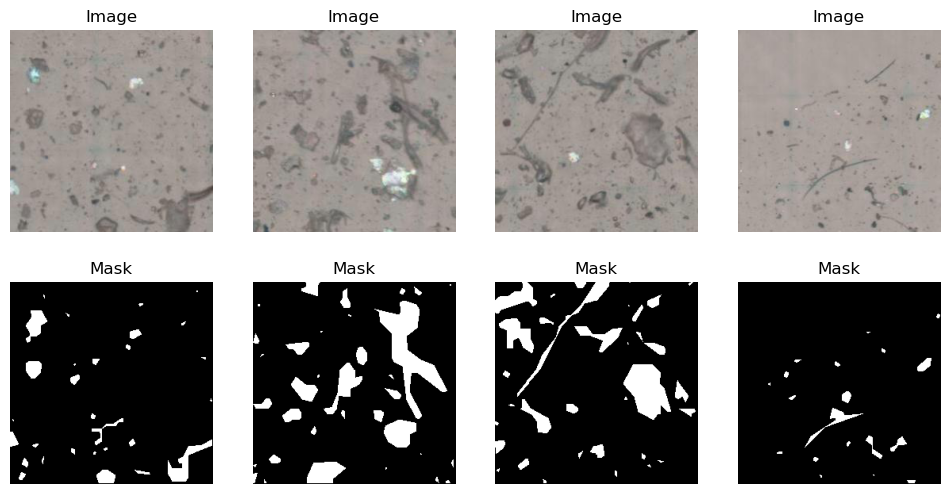

Inspecting validation dataloader:


Exception ignored in: <function _releaseLock at 0x7fdd3afb34c0>
Traceback (most recent call last):
  File "/home/thibault.schowing/data-local/miniconda3/envs/lightning_tutorials/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Batch 0:
Images shapes: torch.Size([16, 3, 256, 256])
Images types: torch.float32
Masks shapes: torch.Size([16, 1, 256, 256])
Masks types: torch.float32


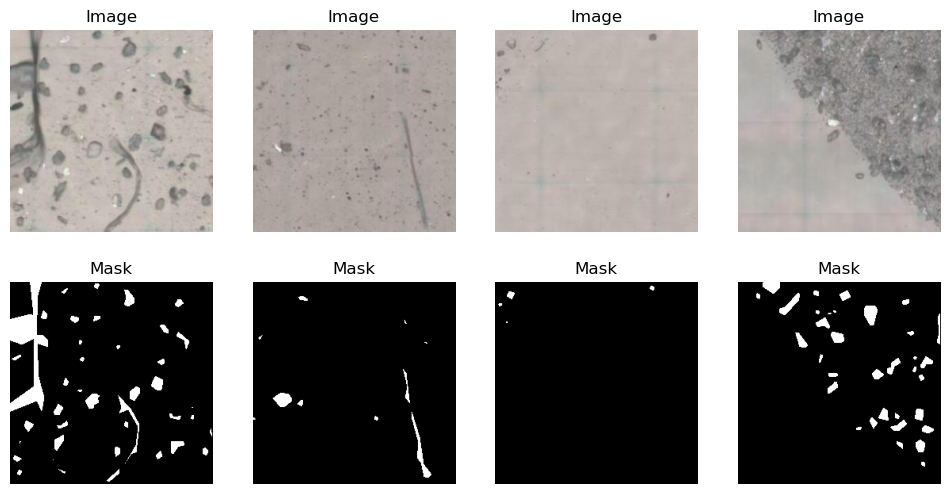

Inspecting test dataloader:
Batch 0:
Images shapes: torch.Size([16, 3, 256, 256])
Images types: torch.float32
Masks shapes: torch.Size([16, 1, 256, 256])
Masks types: torch.float32


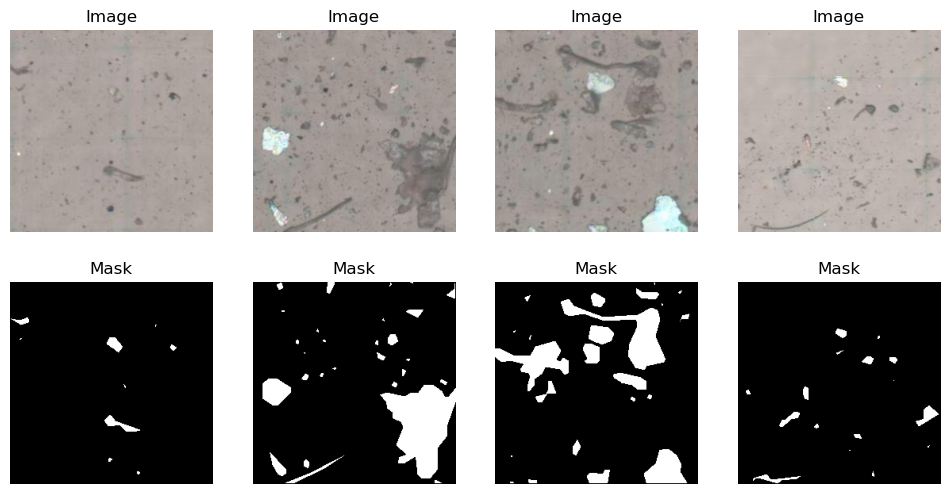

In [10]:
# Assuming data_module is already defined and set up
data_module = CustomDataModule(data_dir, batch_size=16, train_val_test_split=train_val_test_split)
data_module.setup()

# Function to inspect the DataLoader
def inspect_dataloader(dataloader):
    for batch_idx, (images, masks) in enumerate(dataloader):
        print(f"Batch {batch_idx}:")
        print(f"Images shapes: {images.shape}")
        print(f"Images types: {images.dtype}")
        print(f"Masks shapes: {masks.shape}")
        print(f"Masks types: {masks.dtype}")
        
        # Display a few images and masks
        if batch_idx == 0:
            fig, axs = plt.subplots(2, 4, figsize=(12, 6))
            for i in range(4):
                axs[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
                axs[0, i].set_title("Image")
                axs[0, i].axis("off")

                axs[1, i].imshow(masks[i].squeeze().cpu().numpy(), cmap="gray")
                axs[1, i].set_title("Mask")
                axs[1, i].axis("off")
            plt.show()
        break

# Inspect the train dataloader
print("Inspecting train dataloader:")
inspect_dataloader(data_module.train_dataloader())

# Inspect the validation dataloader
print("Inspecting validation dataloader:")
inspect_dataloader(data_module.val_dataloader())

# Inspect the test dataloader
print("Inspecting test dataloader:")
inspect_dataloader(data_module.test_dataloader())

Visualize data

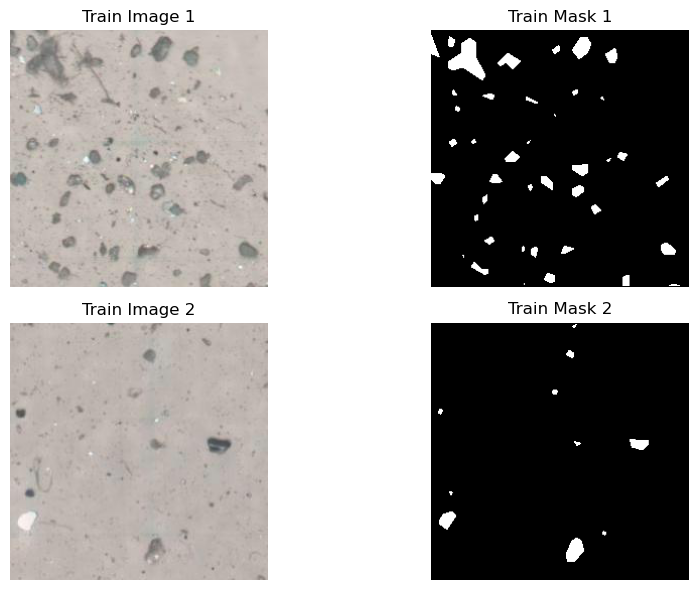

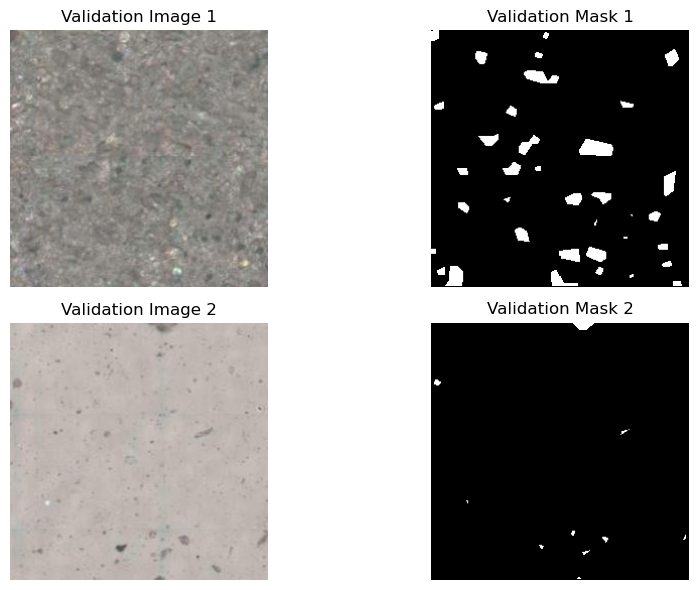

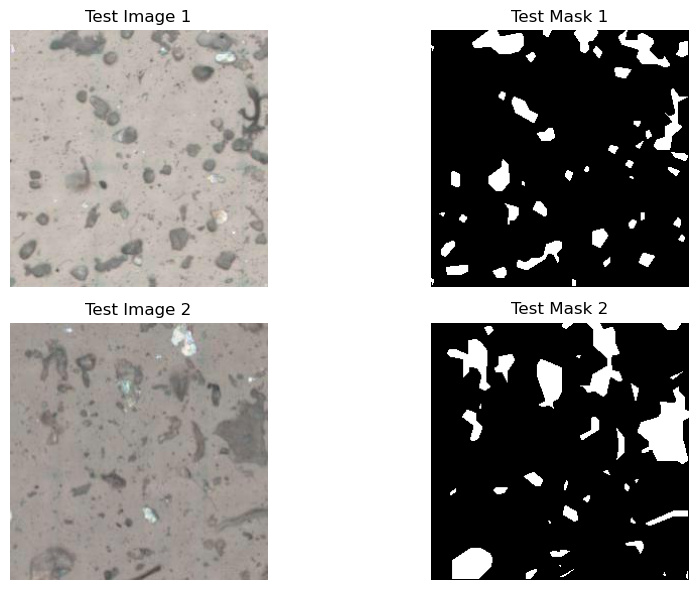

In [ ]:
# Get a few samples from each dataset
train_samples = [data_module.train_data[i] for i in range(2)]
val_samples = [data_module.val_data[i] for i in range(2)]
test_samples = [data_module.test_data[i] for i in range(2)]



# Visualize a few samples from each dataset
def visualize_samples(samples, dataset_name):
    fig, axes = plt.subplots(len(samples), 2, figsize=(10, len(samples) * 3))
    for i, (image, mask) in enumerate(samples):
        axes[i, 0].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[i, 0].set_title(f'{dataset_name} Image {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f'{dataset_name} Mask {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
# Visualize samples
visualize_samples(train_samples, 'Train')
visualize_samples(val_samples, 'Validation')
visualize_samples(test_samples, 'Test')

In [ ]:
# Keep to see tensors dimensions and types


#
# Create a CustomDataset instance
#

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()
])

ds = CustomDataset(data_dir, transform=train_transform, target_transform=target_transform)
print(len(ds))

# Data loader with all the data
# dl = DataLoader(ds, batch_size=batch_size, shuffle=True)


#
# Split the dataset into train, validation, and test sets
#

total_samples = len(ds)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_set, val_set, test_set = random_split(ds, [train_size, val_size, test_size])

# Create DataLoader instances for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


for images, masks in test_loader:
    
    print(f"Images shapes: {images.shape}")
    print(f"Image types: {images.dtype}")
    
    print(f"Masks shapes: {masks.shape}")
    print(f"Masks types: {masks.dtype}")
    break


---

## Drafts, tests and usefull trials

---

### Visualisation of the dataset images and masks sizes. 

In [ ]:
# Shows the unique image and masks sizes in the directory
# -> not all equal -> need to resize -> done

import os
from PIL import Image

def list_unique_image_sizes(directory):
    image_sizes = set()

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        # Check if the file is an image (JPEG or PNG)
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Open the image using PIL
            with Image.open(filepath) as img:
                # Get the size of the image (width x height)
                size = img.size
                # Add the size to the set of unique sizes
                image_sizes.add(size)

    return image_sizes

# Directory containing images and masks
directory = '/mnt/remote/workspaces/thibault.schowing/0_DATA/IMPTOX/00_Dataset/uFTIR_CurSquareSemantic.v1i.png-mask-semantic/train'

# List unique image sizes
unique_sizes = list_unique_image_sizes(directory)

# Print the unique image sizes
print("Unique Image Sizes:")
for size in unique_sizes:
    print(f"{size[0]} x {size[1]}")


Unique Image Sizes:
256 x 255
255 x 256
256 x 256
255 x 255


### Trials with reading the COCO dataset

Note: after switching to image/mask dataset, it was realized that the images and masks don't have regular sizes (varying 1px). Maybe resizing the images can solve some problems. 

In [ ]:


class MyLightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = YourModel()
        self.data_module = CustomCOCODataModule(data_dir='../../../../0_DATA/IMPTOX/00_Dataset/uFTIR_curated_square.v5-uftir_curated_square_2024-03-14.coco-segmentation/train')
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        # Your training logic
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        # Your validation logicdddd
        return {'val_loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)
    
class ResNetModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

class COCOModule(pl.LightningModule):
    def __init__(self, data_dir, num_classes=1, batch_size=32, num_workers=4, train_val_split=0.8):
        super().__init__()
        self.data_module = CustomCOCODataModule(data_dir=data_dir, 
                                                batch_size=batch_size, 
                                                num_workers=num_workers, 
                                                train_val_split=train_val_split)
        self.model = ResNetModel(num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        return self.model.training_step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.model.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return self.model.configure_optimizers()

    def train_dataloader(self):
        return self.data_module.train_dataloader()

    def val_dataloader(self):
        return self.data_module.val_dataloader()

In [ ]:
class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, coco, img_ids, data_dir, transform=None):
        self.coco = coco
        self.img_ids = img_ids
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_data = self.coco.loadImgs(img_id)[0]
        img_file_name = img_data['file_name']
        img = Image.open(os.path.join(self.data_dir, img_file_name)).convert('RGB')
        if self.transform:
            img = self.transform(img)

        # Extract class label
        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'])
        
        
        target = self.coco.loadAnns(ann_ids)[0]['category_id']

        return img, target

In [ ]:
class CustomCocoDataset(torch.utils.data.Dataset):
    
    def __init__(self, annFile, img_ids, data_dir, transform=None, target_transform=None):
        self.coco = annFile
        self.img_ids = img_ids
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

In [ ]:
class CustomCOCODataModule(LightningDataModule):
    def __init__(self, data_dir, image_size=(256, 256), batch_size=32, num_workers=4, train_val_test_split=(0.8, 0.1, 0.1)):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_val_test_split = train_val_test_split
        self.image_size = image_size

    def prepare_data(self):
        # Download or preprocess your data here
        pass

    def setup(self, stage=None):
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        coco = COCO(os.path.join(self.data_dir, '_annotations.coco.json'))
        
        annFile = os.path.join(self.data_dir, '_annotations.coco.json')

        # Get image ids
        img_ids = coco.getImgIds()

        # Split dataset into train, val, and test
        dataset_size = len(img_ids)
        train_size = int(dataset_size * self.train_val_test_split[0])
        val_size = int(dataset_size * self.train_val_test_split[1])
        test_size = dataset_size - train_size - val_size
        train_ids, val_ids, test_ids = img_ids[:train_size], img_ids[train_size:train_size + val_size], img_ids[train_size + val_size:]

        self.train_dataset = CustomCocoDataset(annFile, train_ids, self.data_dir, coco, transform=transform)
        self.val_dataset = CustomCocoDataset(annFile, val_ids, self.data_dir, coco, transform=transform)
        self.test_dataset = CustomCocoDataset(annFile, test_ids, self.data_dir, coco, transform=transform)

        # Check if images can be loaded successfully
        #self._verify_dataset(self.train_dataset, "Train")
        #self._verify_dataset(self.val_dataset, "Validation")
        #self._verify_dataset(self.test_dataset, "Test")

    def _verify_dataset(self, dataset, name):
        print(f"\nChecking {name} dataset...")
        for i in range(5):  # Check the first 5 images
            image, target = dataset[i]
            image_path = os.path.join(self.data_dir, target['file_name'])
            print(f"Image path: {image_path}")
            try:
                Image.open(image_path)
                print(f"Image {i + 1} - Success:", image_path)
            except Exception as e:
                print(f"Image {i + 1} - Error:", image_path)
                print(e)

    def train_dataloader(self):
        if self.train_dataset is not None:
            return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)
        else:
            raise ValueError("No training dataset created yet. Please call the setup method first.")

    def val_dataloader(self):
        if self.val_dataset is not None:
            return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        else:
            raise ValueError("No validation dataset created yet. Please call the setup method first.")

    def test_dataloader(self):
        if self.test_dataset is not None:
            return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        else:
            raise ValueError("No test dataset created yet. Please call the setup method first.")
        
        
class CustomCocoDataset(CocoDetection):
    def __init__(self,
                 annFile,
                 img_ids,
                 data_dir,
                 coco,
                 transform=None,
                 target_transform=None,
                 image_size=(256, 256)) -> None:
        super().__init__(data_dir, annFile, transform, target_transform)
        self.img_ids = img_ids
        self.image_size = image_size
        self.coco = coco

    def __getitem__(self, index: int):
        img_id = self.img_ids[index]
        img, target = self.coco.loadImgs(img_id)[0], self.coco.loadAnns(self.coco.getAnnIds(img_id))
        # Resize image
        img = resize(img, self.image_size)
        # do whatever you want
        return img, target
    
